In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import pdb
import matplotlib.pyplot as plt
import cartopy
from utils import u_plot as up, u_darrays
import cartopy.crs as ccrs
import os
import matplotlib as mpl
import pickle as pkl
from utils import constants as cnst, u_darrays, u_grid, u_plot
from scipy.ndimage.measurements import label
import ipdb

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [145]:
ts = xr.open_mfdataset(cnst.CHIRPS + "*.nc")#"/global/chirps-v2.0.monthly.nc")
WA = [-15,15,4,9]
SA = [5,55,-40,0]

In [146]:
mean_years = ts.sel(longitude=slice(WA[0], WA[1]), latitude=slice(WA[2], WA[3]))

#mean_years = u_darrays.flip_lat(mean_years)
mean_years = (mean_years['rainfall'])[(mean_years['time.month']==10)]# & (mean_years['time.month']<=5)]

In [147]:
mean_years = u_darrays.to_newarray(mean_years)

In [131]:
np.percentile(mean_years.values[mean_years.values>1], 90)

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


22.58351860046387

In [132]:
#mean_years = mean_years.groupby('time.year').mean('time') mean rain trend
mean_years = mean_years.where((mean_years >= 12), other=0)
mean_years.values[mean_years.values>=12] = 1

In [148]:
mean_y = u_grid.refactor_da(mean_years, 0.25, method=np.mean)

In [149]:
grouped_y = mean_y.groupby('time.year').sum('time')

In [150]:
np.nanmax(grouped_y.values)

673.6527

In [151]:
grouped_y

<xarray.DataArray (year: 35, latitude: 12, longitude: 75)>
array([[[  0.      ,   0.      , ..., 212.22461 , 210.47787 ],
        [  0.      ,   0.      , ..., 212.22795 , 229.15755 ],
        ...,
        [  0.      ,   0.      , ..., 102.65825 ,  85.6593  ],
        [  0.      ,   0.      , ...,  63.35827 ,  69.09027 ]],

       [[  0.      ,   0.      , ..., 292.7504  , 260.301   ],
        [  0.      ,   0.      , ..., 296.55685 , 288.3761  ],
        ...,
        [  0.      ,   0.      , ..., 130.69228 , 100.46086 ],
        [  0.      ,   0.      , ..., 109.12023 , 113.28194 ]],

       ...,

       [[  0.      ,   0.      , ..., 263.1814  , 239.7595  ],
        [  0.      ,   0.      , ..., 225.23691 , 222.90958 ],
        ...,
        [  0.      ,   0.      , ..., 111.32557 , 125.36172 ],
        [  0.      ,   0.      , ...,  80.00411 ,  87.18381 ]],

       [[  0.      ,   0.      , ..., 249.3581  , 236.92242 ],
        [  0.      ,   0.      , ..., 275.24713 , 296.73364 ],
 

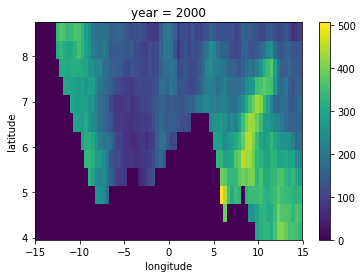

In [152]:
grouped_y[19,:,:].plot.pcolormesh()

In [153]:
grouped_y

<xarray.DataArray (year: 35, latitude: 12, longitude: 75)>
array([[[  0.      ,   0.      , ..., 212.22461 , 210.47787 ],
        [  0.      ,   0.      , ..., 212.22795 , 229.15755 ],
        ...,
        [  0.      ,   0.      , ..., 102.65825 ,  85.6593  ],
        [  0.      ,   0.      , ...,  63.35827 ,  69.09027 ]],

       [[  0.      ,   0.      , ..., 292.7504  , 260.301   ],
        [  0.      ,   0.      , ..., 296.55685 , 288.3761  ],
        ...,
        [  0.      ,   0.      , ..., 130.69228 , 100.46086 ],
        [  0.      ,   0.      , ..., 109.12023 , 113.28194 ]],

       ...,

       [[  0.      ,   0.      , ..., 263.1814  , 239.7595  ],
        [  0.      ,   0.      , ..., 225.23691 , 222.90958 ],
        ...,
        [  0.      ,   0.      , ..., 111.32557 , 125.36172 ],
        [  0.      ,   0.      , ...,  80.00411 ,  87.18381 ]],

       [[  0.      ,   0.      , ..., 249.3581  , 236.92242 ],
        [  0.      ,   0.      , ..., 275.24713 , 296.73364 ],
 

In [154]:
def calc_trend(mean_years, method='mk', sig=False):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0
            
    return dtrend

In [160]:
trend=calc_trend(grouped_y)

Entering trend calc


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [161]:
trend['slope'].values = trend['slope'].values*10

In [162]:
mean = grouped_y.mean('year')

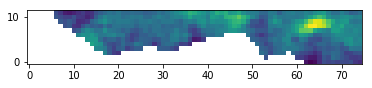

In [163]:
plt.figure()
plt.imshow(trend['slope'], origin='lower')

In [159]:
trend['slope'].values[trend['pval'].values>0.05] = 0

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [164]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(10,8), dpi=300)  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),**kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.pcolormesh(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        con = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=0.5 )
        plt.clabel(con, inline=True, fontsize=7, fmt='%1.1f')
        
    if contour2 is not None:
        con = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], colors='r', linewidths=0.5 )
        plt.clabel(con, inline=True, fontsize=7, fmt='%1.1f')
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label) 
    f.canvas.draw()
    plt.tight_layout()
    #plt.savefig(cnst.network_data + 'figs/CLOVER/SA/CHIRPS_trend.pdf')

In [173]:
map = grouped_y.salem.get_map()
#contour = {'x' : mean_y['longitude'].values, 'y': mean_y['latitude'].values, 'data': clim, 'levels': np.linspace(50, 300, 5)}
#contour2 = {'x' : mean_y['longitude'].values, 'y': mean_y['latitude'].values, 'data': clim, 'levels': np.linspace(25, 75, 2)}
# draw_map(trend['slope'], mean_y['longitude'].values, mean_y['latitude'].values, cmap='RdBu', extend='both', levels = [-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1] ,
#         cbar_label='mm month$^{-1}$ decade$^{-1}$', title='CHIRPS rainfall trend 1981-2019, NDJ')  #[-10,-8,-6,-4,-2,2,4,6,8,10]

In [178]:
np.nanmax((trend['slope'].values/mean.values)*100)

21.548542410572587

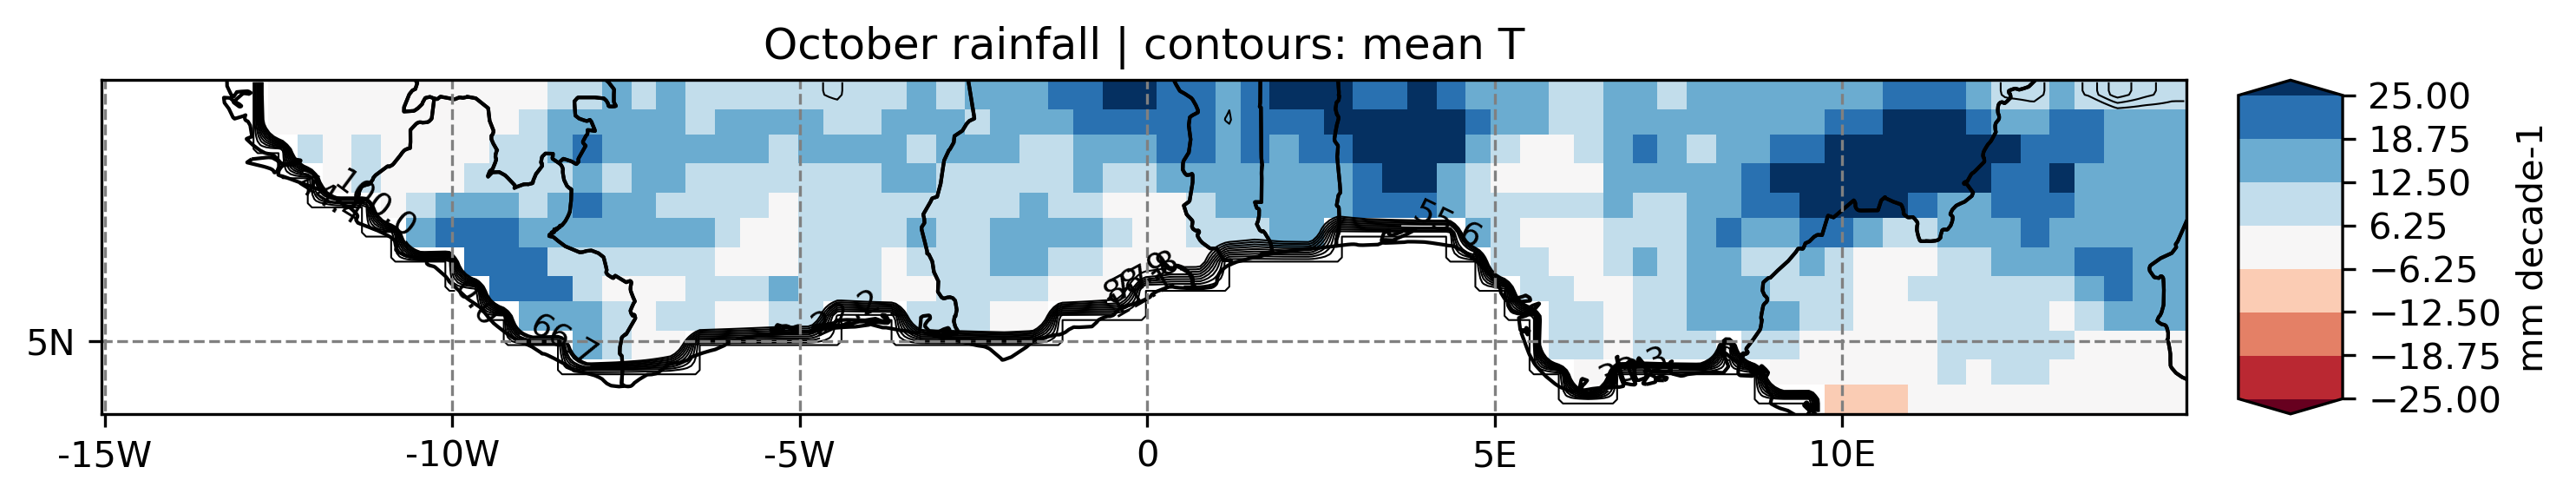

In [182]:
f = plt.figure(figsize=(10,2), dpi=300)


ax1 = f.add_subplot(111)
map.set_data(trend['slope'])  # interp='linear'
map.set_plot_params(levels=np.array([-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1])*25, cmap='RdBu', extend='both')  # levels=np.arange(-0.5,0.51,0.1),

map.set_contour((mean.values).astype(np.float64), interp='linear', colors='k', linewidths=0.5, levels=np.linspace(0,100,10))
#map.set_plot_params(levels=[-0.5,-0.4,-0.3,-0.2,-0.1,-0.05,-0.02, 0.02,0.05,0.1,0.2,0.3,0.4,0.5], cmap='RdBu_r', extend='both')  # levels=np.arange(-0.5,0.51,0.1),

dic = map.visualize(ax=ax1, title='October rainfall | contours: mean T', cbar_title='mm decade-1')
contours = dic['contour'][0]
plt.clabel(contours, inline=True, fontsize=9, fmt='%1.1f')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/CLOVER/CHIRPS/OCT_PCP_trend.png')